# Finite Groups (Dihedral Only)

This notebook runs the modular arithmetic task on any finite group (available in package escnn) using the regular representation acting on the domain of the encoding vector `template`.

This is only a work in progress

In [4]:
from escnn.group import *

import matplotlib.pyplot as plt
import numpy as np

group = DihedralGroup(3)

g = group.elements[3]
g.param # use this to do the defining representation instead

group.PARAMETRIZATIONS

g.to("MAT")

(1,
 array([[ 1., -0.],
        [ 0.,  1.]]))

type(mat): <class 'numpy.ndarray'>, mat=[[ 1. -0.]
 [ 0.  1.]]
type(mat): <class 'numpy.ndarray'>, mat=[[-0.5       -0.8660254]
 [ 0.8660254 -0.5      ]]
type(mat): <class 'numpy.ndarray'>, mat=[[-0.5        0.8660254]
 [-0.8660254 -0.5      ]]
type(mat): <class 'numpy.ndarray'>, mat=[[ 1. -0.]
 [ 0.  1.]]
type(mat): <class 'numpy.ndarray'>, mat=[[-0.5       -0.8660254]
 [ 0.8660254 -0.5      ]]
type(mat): <class 'numpy.ndarray'>, mat=[[-0.5        0.8660254]
 [-0.8660254 -0.5      ]]


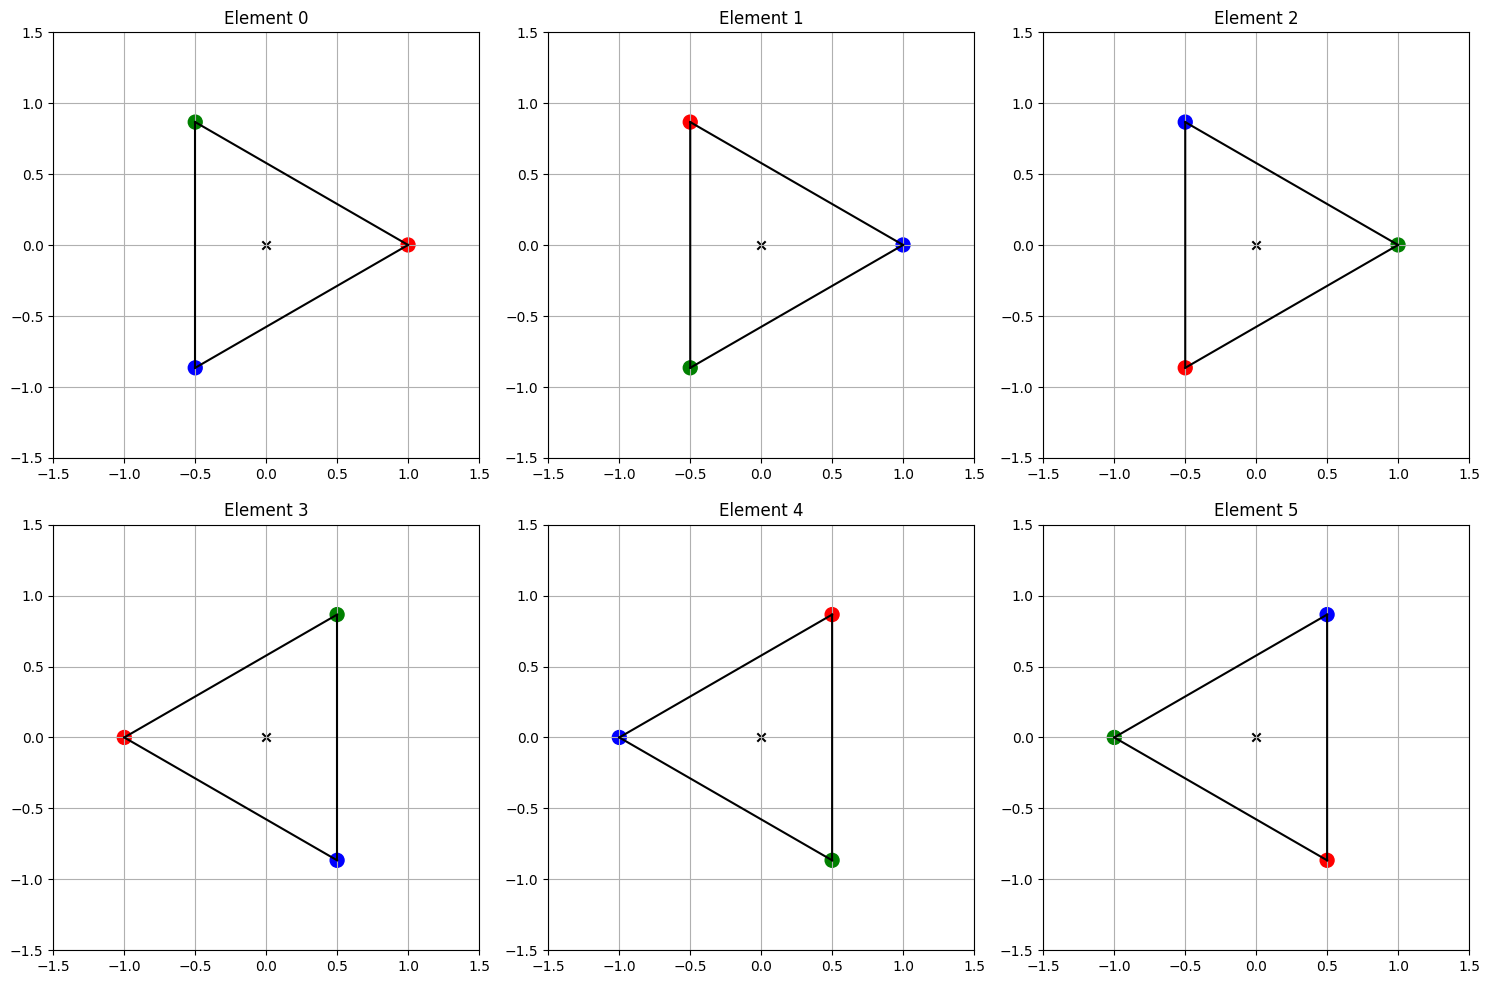

In [ ]:
# Define triangle vertices and colors
triangle = np.array([
    [1, 0],      # First vertex
    [-0.5, 0.866],  # Second vertex 
    [-0.5, -0.866]  # Third vertex
])

# Define colors for vertices
colors = ['red', 'green', 'blue']

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot for each group element
for idx, g in enumerate(group.elements):
    # Get transformation matrix
    s, mat = g.to("MAT")
    
    # Transform triangle vertices
    transformed = triangle @ mat.T
    # Apply reflection if s=1 (reflection element)
    if s == 1:
        transformed = transformed * [-1, 1]  # Reflect across y-axis
    
    # Plot original points with colors
    ax = axes[idx]
    ax.scatter(transformed[:,0], transformed[:,1], c=colors, s=100)
    
    # Plot triangle edges by connecting vertices
    # Connect vertices in order, including back to first vertex
    for i in range(len(transformed)):
        j = (i + 1) % len(transformed)  # Next vertex (wraps around to 0)
        ax.plot([transformed[i,0], transformed[j,0]], 
                [transformed[i,1], transformed[j,1]], 
                'k-')  # Black solid line
    
    # Plot barycenter (origin)
    ax.scatter(0, 0, c='black', marker='x')
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    # Add grid
    ax.grid(True)
    
    # Add title showing group element
    ax.set_title(f'Element {idx}')

plt.tight_layout()
plt.show()


In [7]:
group.PARAMETRIZATIONS  

['int', 'radians', 'MAT']

In [13]:
group.elements[1]

(+, 1[2pi/3])

In [ ]:
# TODO: Check if dataset is correctly centered (see paper on generating dataset)
def group_dataset(group, template, representation="defining"):
    """Generate a dataset of group elements acting on the template.

    Using the "defining" representation.

    N = group.order() // 2 for the dihedral group.
    
    Parameters
    ----------
    group : Group (escnn object)
        The group.
    template : np.ndarray, shape=[N]
        The template to generate the dataset from.

    Returns
    -------
    X : np.ndarray, shape=[N**2, 2, N]
        The dataset of group elements acting on the template.   
    Y : np.ndarray, shape=[N**2, N]
        The dataset of group elements acting on the template.
    """
        
    # Initialize data arrays
    N = group.order() // 2

    # This create a "template" of N points on the unit circle
    # such that each point is associated with a scalar value (its color)
    assert len(template) == N, "template must have the same length as the group order"
    template_coordinates = np.array([
        [np.cos(2 * np.pi * k / N), np.sin(2 * np.pi * k / N)] 
        for k in range(N)
    ])

    n_samples = N ** 2
    X = np.zeros((n_samples, 2, N))
    Y = np.zeros((n_samples, N))

    # Generate transformed coordinates and values for each group element
    transformed_coords = np.zeros((len(group.elements), N, 2))
    transformed_values = np.zeros((len(group.elements), N))
    
    for i, g in enumerate(group.elements):
        # Decompose into sign and rotation matrix
        s, mat = g.to("MAT")
        
        # Transform coordinates by applying rotation matrix
        rotated_coords = template_coordinates @ mat.T
        
        # Apply reflection if s = -1
        if s > 0:
            rotated_coords = -rotated_coords
            
        transformed_coords[i] = rotated_coords
        
        # Similarly transform the template values
        transformed_values[i] = template if s > 0 else template[::-1]
    
    # Generate the dataset
    idx = 0
    for a in range(N):
        for b in range(N):
            for sa in (-1, 1):
                for sb in (-1, 1):  
                    X[idx, 0, :] = np.roll(template, a)[::sa] # reverse or does not reverse the order, depending on sa.
                    X[idx, 1, :] = np.roll(template, b)[::sb]
                    Y[idx, :] = np.roll(np.roll(template, a)[::sa], b)[::sb]
                    idx += 1
            
    return X, Y